# <center><h1 style = "color:navy;">Time Series Analysis on Power Supply</h1></center>

In [ ]:
#required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
sns.set_palette('Set2')
from statsmodels.tsa.seasonal import STL

In [ ]:
#load data
df = pd.read_csv('/content/PJMW_hourly.csv')

In [ ]:
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169905 entries, 0 to 169904
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  169905 non-null  object 
 1   PJMW_MW   169904 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.6+ MB


In [ ]:
df.shape

(169905, 2)

#### <h3 style="color:midnightblue">Visualizing the raw power supply distribution</h3>

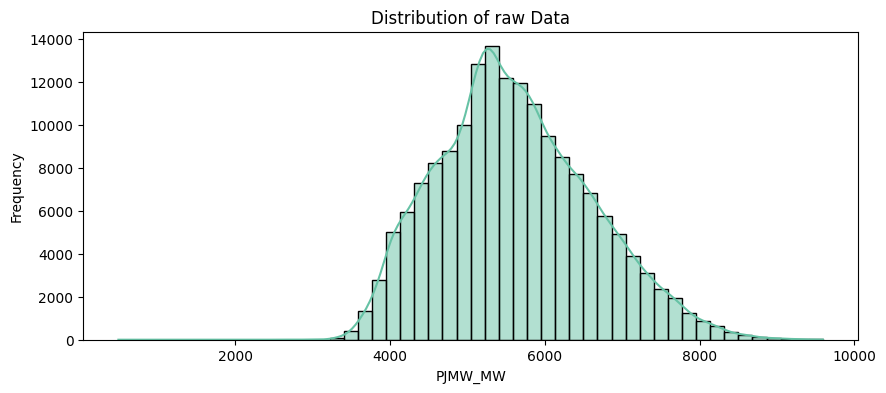

In [ ]:
#Histogram showing distribution of data
plt.figure(figsize=(10, 4))
sns.histplot(df['PJMW_MW'].dropna(),bins=50, kde=True)
plt.title('Distribution of raw Data')
plt.xlabel('PJMW_MW')
plt.ylabel('Frequency')
plt.show()

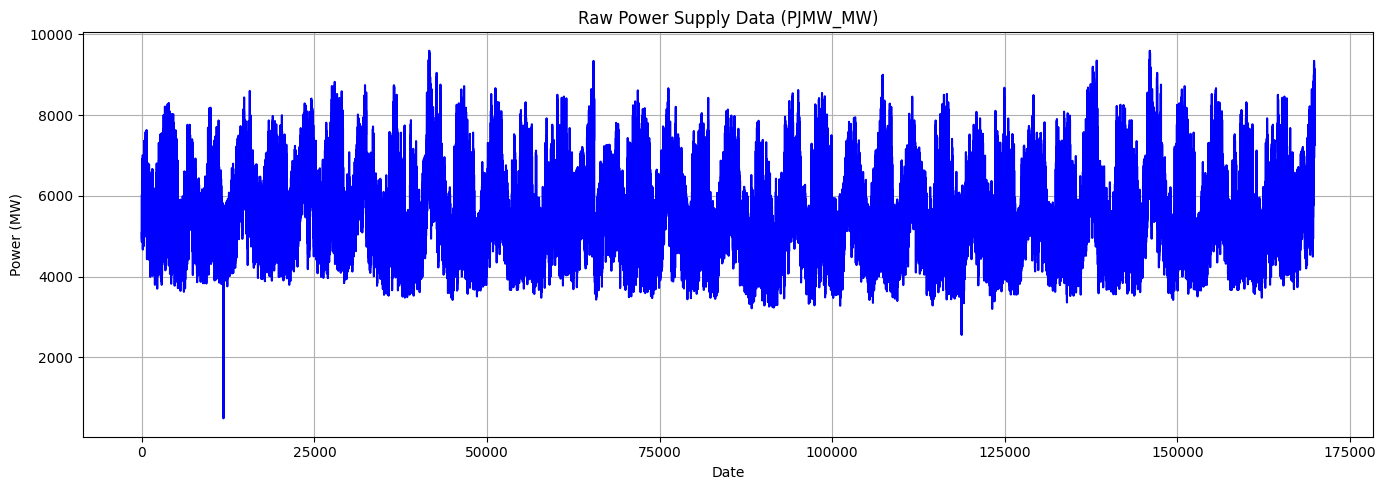

In [ ]:
# Plot line graph of the raw data
plt.figure(figsize=(14, 5))
plt.plot(df['PJMW_MW'], color='blue')
plt.title('Raw Power Supply Data (PJMW_MW)')
plt.xlabel('Date')
plt.ylabel('Power (MW)')
plt.tight_layout()
plt.grid(True)
plt.show()

## <h2 style="color:purple">EDA Pipeline</h2>
#### <h3 style="color:midnightblue">1. Check  for duplicates</h3>

We are checking for duplicates in Datatime column before setting up the index.

In [ ]:
def check_duplicates(df):
    duplicates = df['Datetime'].duplicated().sum()
    df = df.groupby('Datetime', as_index=False)['PJMW_MW'].mean()   #fixing duplicates
    return duplicates, df

duplicates_found, df = check_duplicates(df)
duplicates_found


np.int64(26702)

In [ ]:
df['Datetime'].duplicated().sum()

np.int64(0)

#### <h3 style="color:midnightblue">2.Data Consistency: Format datetime, set index, and ensure frequency</h3>

In [ ]:
def preprocess_datetime(df, datetime_col):
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df.set_index(datetime_col, inplace=True)
    df = df.sort_index()
    return df.asfreq('H')  # hourly data

df = preprocess_datetime(df, 'Datetime')


<ipython-input-23-afed6e7ec1e7>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[datetime_col] = pd.to_datetime(df[datetime_col])
<ipython-input-23-afed6e7ec1e7>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return df.asfreq('H')  # hourly data


<b style="color:midnightblue">Time range in the dataset</b>`

In [ ]:
#time range
df.head(1)

,PJMW_MW
Datetime,
2002-04-01 01:00:00,4374.0


In [ ]:
df.tail(1)

,PJMW_MW
Datetime,
2025-05-31,5129.0


#### <h3 style="color:midnightblue">3. Handle missing Values</h3>

In [ ]:
df.isna().sum()

,0
PJMW_MW,59862


In [ ]:
def fill_missing_values(df):
    missing_before = df.isna().sum()

    # Try interpolation first
    df_interp = df.interpolate(method='time')

    # Fallback with forward-fill and backward-fill
    df_filled = df_interp.ffill().bfill()

    missing_after = df_filled.isna().sum()
    return df_filled, missing_before, missing_after

df, missing_before, missing_after = fill_missing_values(df)
missing_before, missing_after


(PJMW_MW    59862
 dtype: int64,
 PJMW_MW    0
 dtype: int64)

#### <h3 style="color:midnightblue">4. Detect and treat outliers</h3>

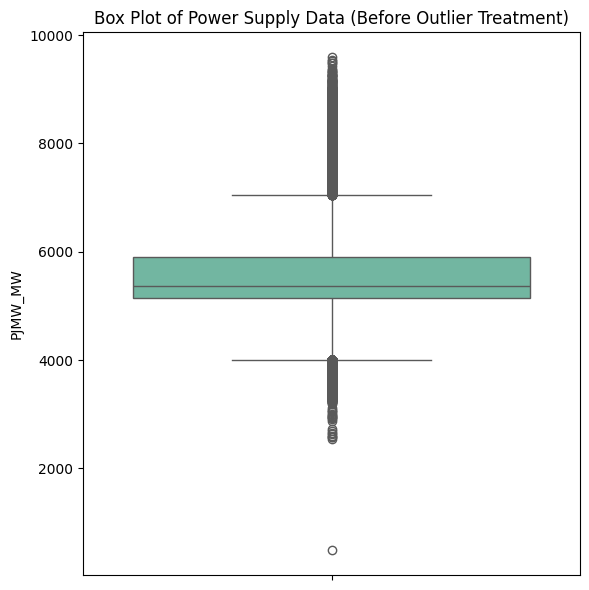

In [ ]:
plt.figure(figsize=(6, 6))
sns.boxplot(y=df['PJMW_MW'])
plt.title('Box Plot of Power Supply Data (Before Outlier Treatment)')
plt.tight_layout()
plt.show()

In [ ]:
def replace_outliers_with_interp(ts, window=None, method='time'):
    """
    Detects outliers using IQR method and replaces them using time interpolation.

    Parameters:
        ts (pd.Series): Time series with datetime index.
        window (int): Optional rolling window to smooth before IQR detection.
        method (str): Interpolation method ('time', 'linear', etc.)

    Returns:
        pd.Series: Time series with outliers replaced via interpolation.
    """
    series = ts.copy()

    # Optional smoothing before detecting outliers
    if window:
        smoothed = series.rolling(window=window, center=True, min_periods=1).mean()
    else:
        smoothed = series

    # IQR calculation
    q1 = smoothed.quantile(0.25)
    q3 = smoothed.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # Mark outliers as NaN
    outliers = (smoothed < lower) | (smoothed > upper)
    series[outliers] = np.nan

    # Interpolate to replace outliers
    series = series.interpolate(method=method)

    return series


In [ ]:
# Without smoothing
cleaned_series = replace_outliers_with_interp(df['PJMW_MW'])
df['PJMW_MW_cleaned'] = cleaned_series
#We are not gonna use rolling window (optional smoothing before detecting outliers),
#because some outliers are not getting detected.

In [ ]:
#df.to_csv('PJMW_hourly_cleaned.csv')
#from google.colab import files
#files.download('PJMW_hourly_cleaned.csv')


In [ ]:
def plot_outlier_removal(original, cleaned, title="Outlier Removal with IQR"):
    plt.figure(figsize=(12, 5))
    plt.plot(original, label='Original', alpha=0.6)
    plt.plot(cleaned, label='Treated (Outliers NaN)', color='red', alpha=0.8)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


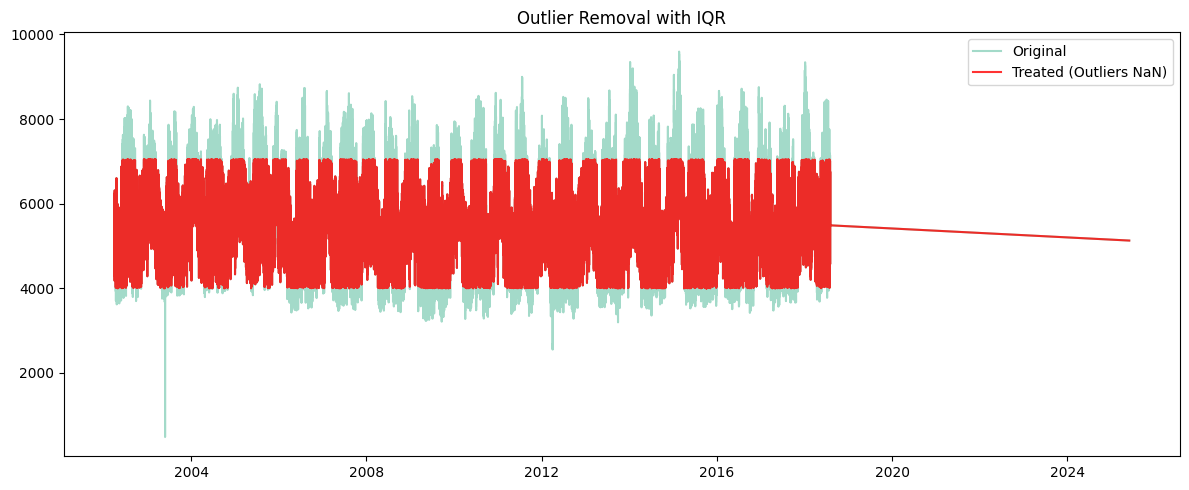

In [ ]:
plot_outlier_removal(df['PJMW_MW'],cleaned_series )

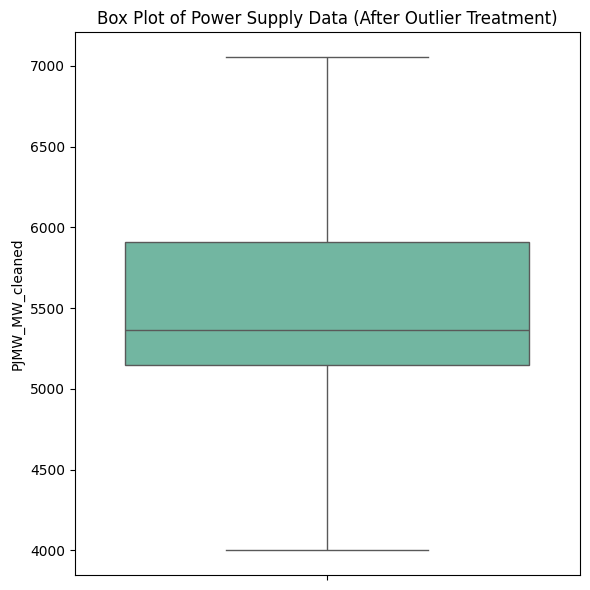

In [ ]:
# Boxplot after treating outliers
plt.figure(figsize=(6, 6))
sns.boxplot(y=df['PJMW_MW_cleaned'])
plt.title('Box Plot of Power Supply Data (After Outlier Treatment)')
plt.tight_layout()
plt.show()


**Cleaned Data distribution**

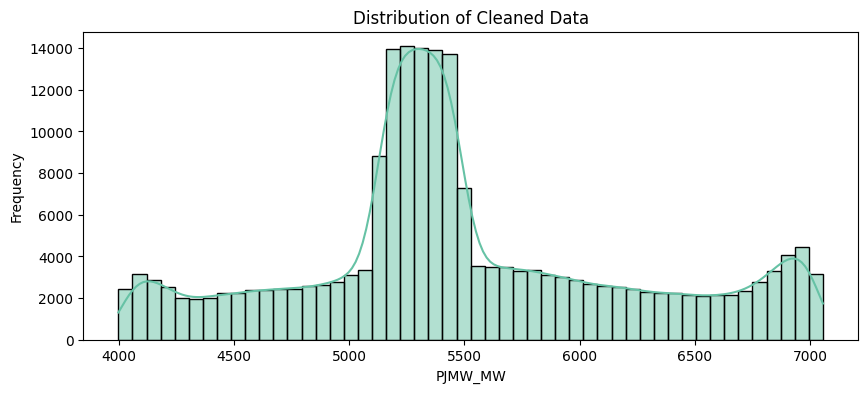

In [ ]:
#Histogram showing distribution of data
plt.figure(figsize=(10, 4))
sns.histplot(df['PJMW_MW_cleaned'].dropna(),bins=50, kde=True)
plt.title('Distribution of Cleaned Data')
plt.xlabel('PJMW_MW')
plt.ylabel('Frequency')
plt.show()

#### <h3 style="color:midnightblue"> 5. Error Trend Seasonality(ETS) Decomposition</h3>

In [ ]:
def plot_ets_decomposition(ts, freq='D', column_name='Value'):
    """
    Perform ETS decomposition on a time series for different seasonal periods.

    Parameters:
        ts (pd.Series): Time series with datetime index
        freq (str): Frequency of decomposition - 'D', 'W', 'M', 'Y'
        column_name (str): Name of the series for plot titles

    Returns:
        Decomposition plots for the selected frequency
    """
    freq_map = {
        'D': 24,         # Daily seasonality (hourly data)
        'W': 24 * 7,     # Weekly seasonality
        'M': 24 * 30,    # Approximate monthly seasonality
        'Y': 24 * 365    # Approximate yearly seasonality
    }

    if freq not in freq_map:
        raise ValueError("Choose freq from: 'D', 'W', 'M', 'Y'")

    period = freq_map[freq]

    decomposition = seasonal_decompose(ts, model='additive', period=period)

    plt.figure(figsize=(10, 8))
    plt.suptitle(f"ETS Decomposition ({freq} Seasonality - {period} steps)", fontsize=14)

    plt.subplot(411)
    plt.plot(ts, label=column_name)
    plt.title(column_name)

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', color='orange')
    plt.title('Trend')

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal', color='green')
    plt.title('Seasonal')

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual', color='red')
    plt.title('Residual')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


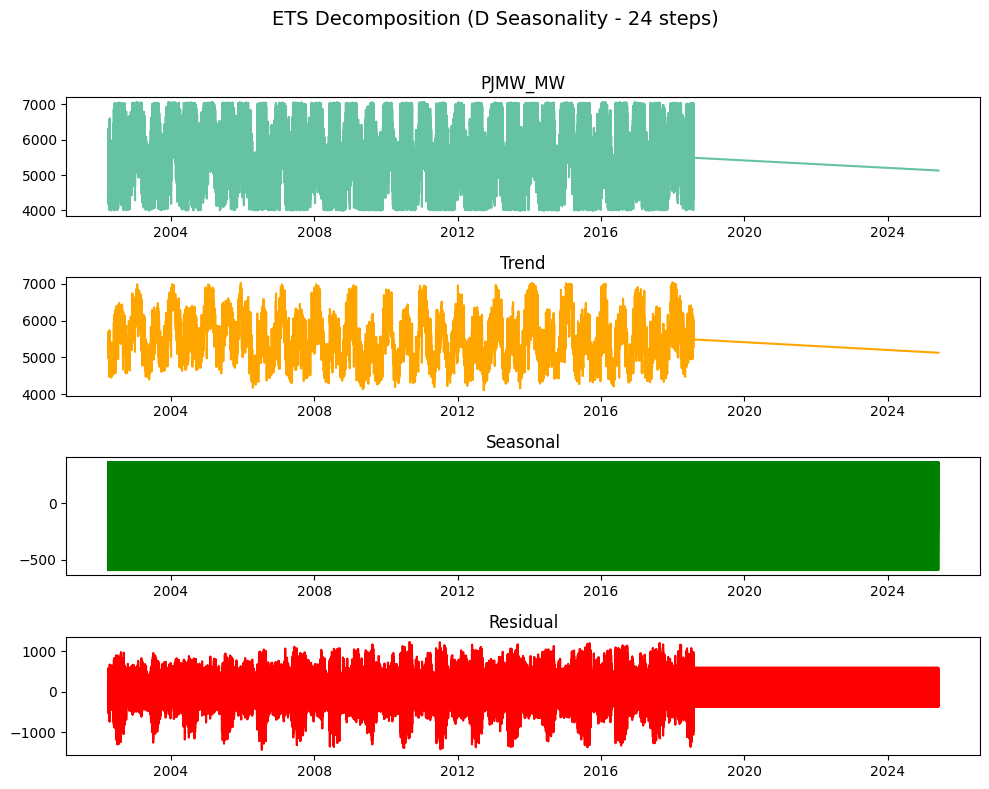

In [ ]:

plot_ets_decomposition(df['PJMW_MW_cleaned'], freq='D', column_name='PJMW_MW')  # Daily


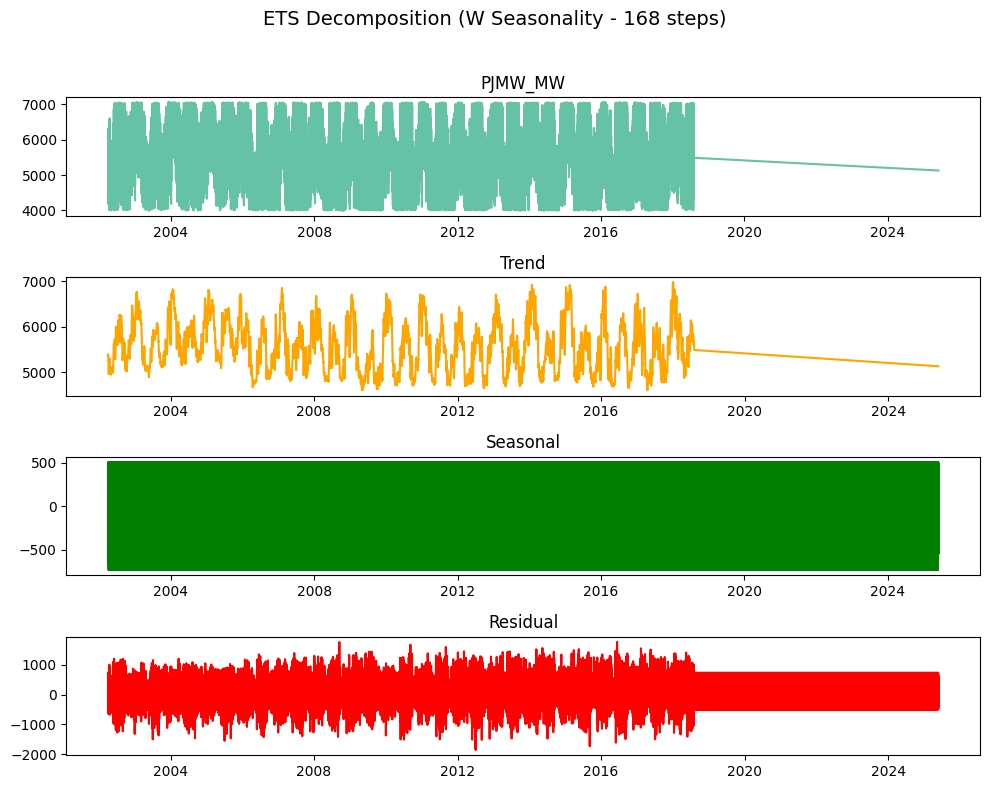

In [ ]:
plot_ets_decomposition(df['PJMW_MW_cleaned'], freq='W', column_name='PJMW_MW')  # Weekly


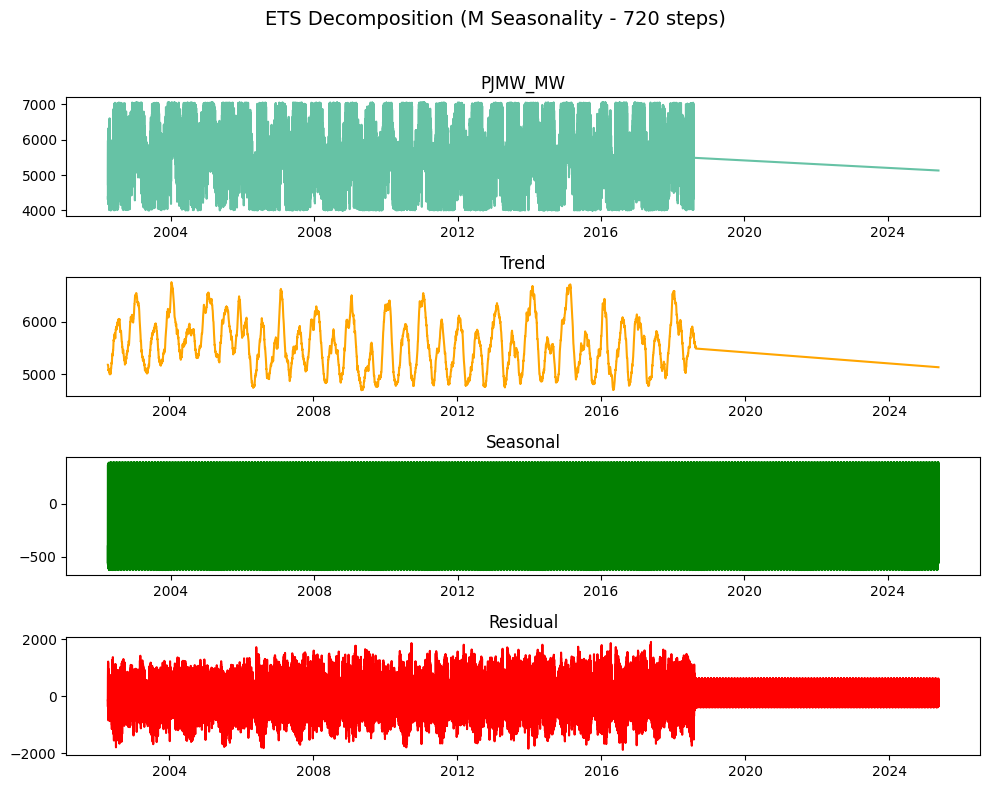

In [ ]:
plot_ets_decomposition(df['PJMW_MW_cleaned'], freq='M', column_name='PJMW_MW')  # Monthly


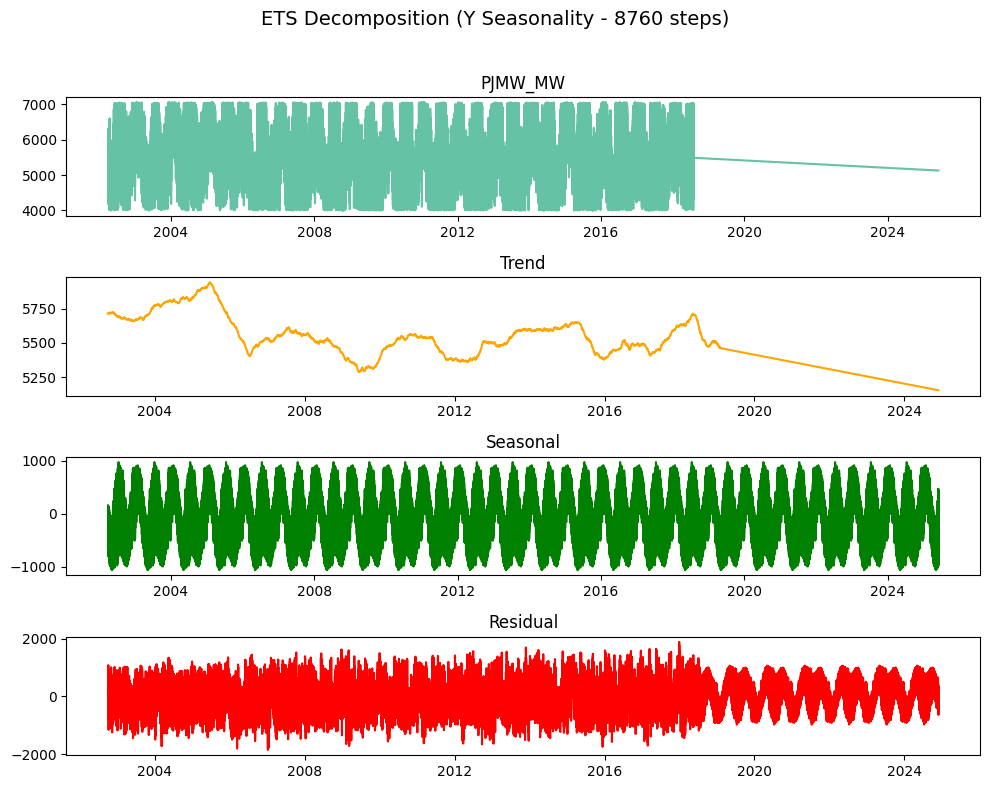

In [ ]:
plot_ets_decomposition(df['PJMW_MW_cleaned'], freq='Y', column_name='PJMW_MW')  # Yearly

**Seasonal Decomposition by Time Series**

In [ ]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

def plot_stl_decomposition(ts, freq='D', column_name='Value'):
    """
    Perform STL decomposition on a time series for different seasonal periods.

    Parameters:
        ts (pd.Series): Time series with datetime index
        freq (str): Frequency of decomposition - 'D', 'W', 'M', 'Y'
        column_name (str): Name of the series for plot titles

    Returns:
        STL decomposition plots for the selected frequency
    """
    freq_map = {
        'D': 24,         # Daily seasonality (hourly data)
        'W': 24 * 7,     # Weekly seasonality
        'M': 24 * 30,    # Approximate monthly seasonality
        'Y': 24 * 365    # Approximate yearly seasonality
    }

    if freq not in freq_map:
        raise ValueError("Choose freq from: 'D', 'W', 'M', 'Y'")

    period = freq_map[freq]
    # Ensure seasonal period is an odd integer >= 3
    if period % 2 == 0:
        period -= 1
    if period < 3:
        raise ValueError("Seasonal period must be >= 3")

    ts_clean = ts.dropna()

    stl = STL(ts_clean, seasonal=period)
    result = stl.fit()


    # Plot results
    plt.figure(figsize=(10, 8))
    plt.suptitle(f"STL Decomposition ({freq} Seasonality - {period} steps)", fontsize=14)

    plt.subplot(411)
    plt.plot(ts_clean, label=column_name)
    plt.title(column_name)

    plt.subplot(412)
    plt.plot(result.trend, label='Trend', color='orange')
    plt.title('Trend')

    plt.subplot(413)
    plt.plot(result.seasonal, label='Seasonal', color='green')
    plt.title('Seasonal')

    plt.subplot(414)
    plt.plot(result.resid, label='Residual', color='red')
    plt.title('Residual')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


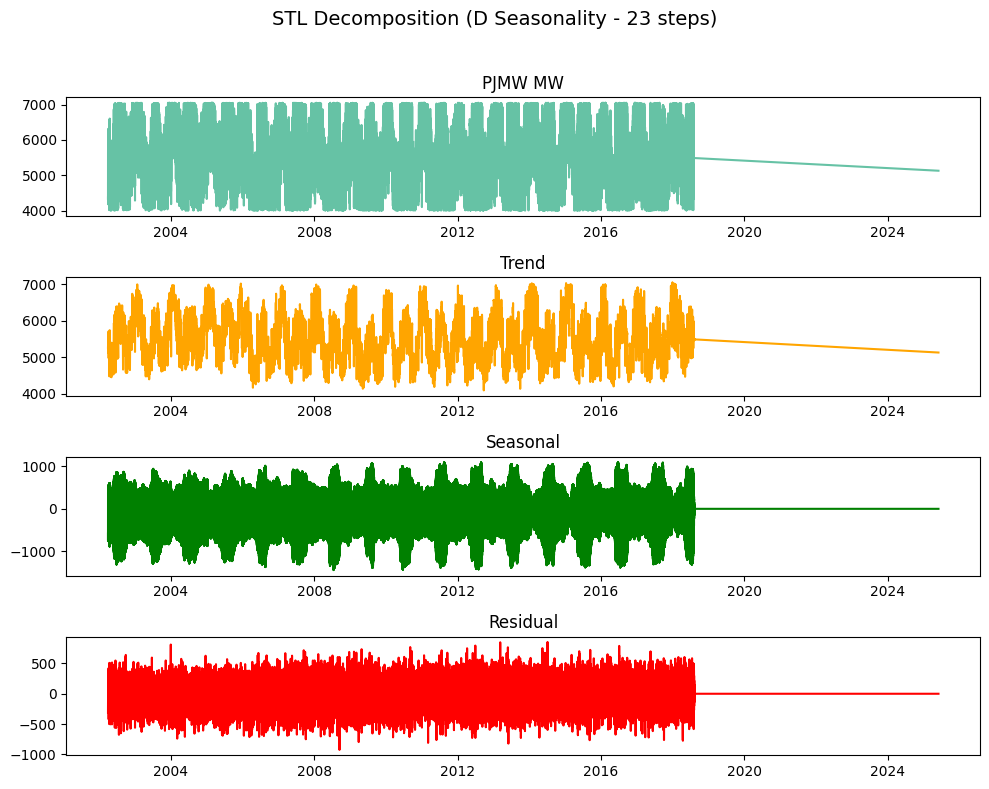

In [ ]:
plot_stl_decomposition(df['PJMW_MW_cleaned'], freq='D', column_name='PJMW MW') #Daily


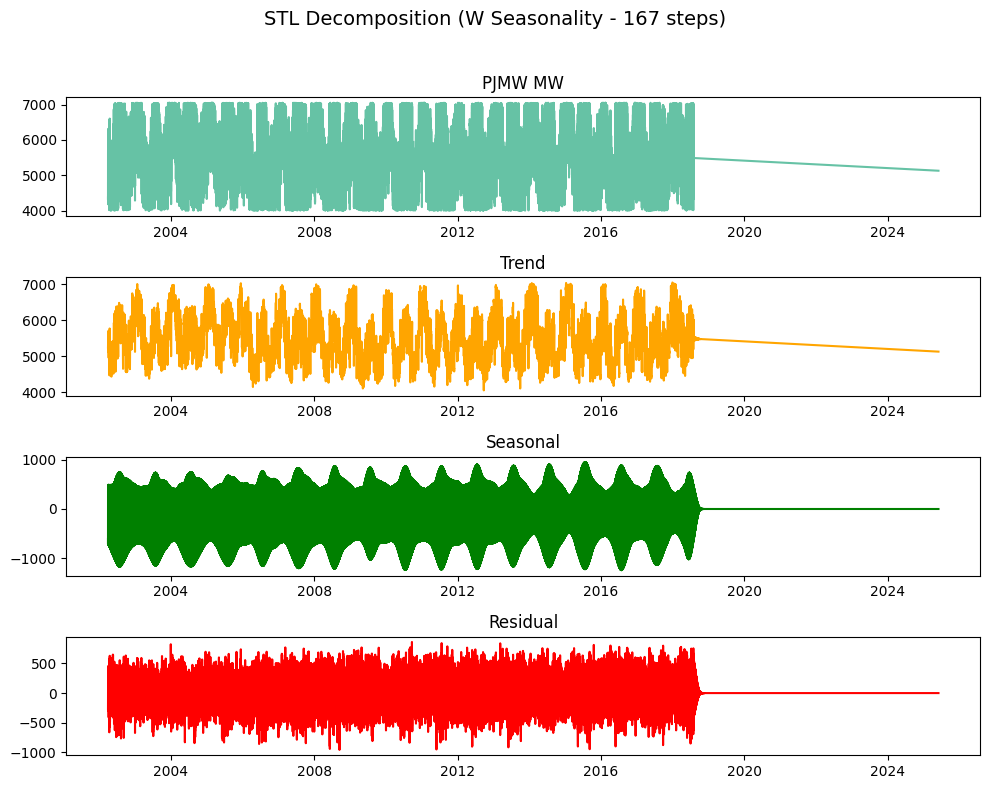

In [ ]:
plot_stl_decomposition(df['PJMW_MW_cleaned'], freq='W', column_name='PJMW MW') #Weekly


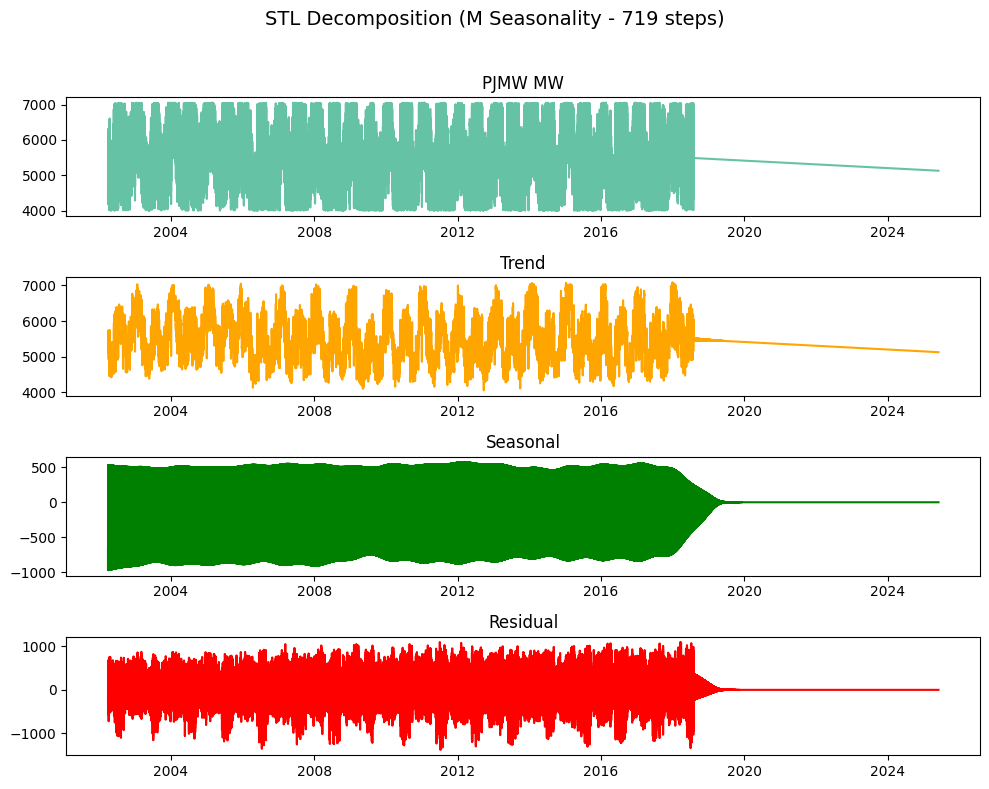

In [ ]:
plot_stl_decomposition(df['PJMW_MW_cleaned'], freq='M', column_name='PJMW MW') #Monthly

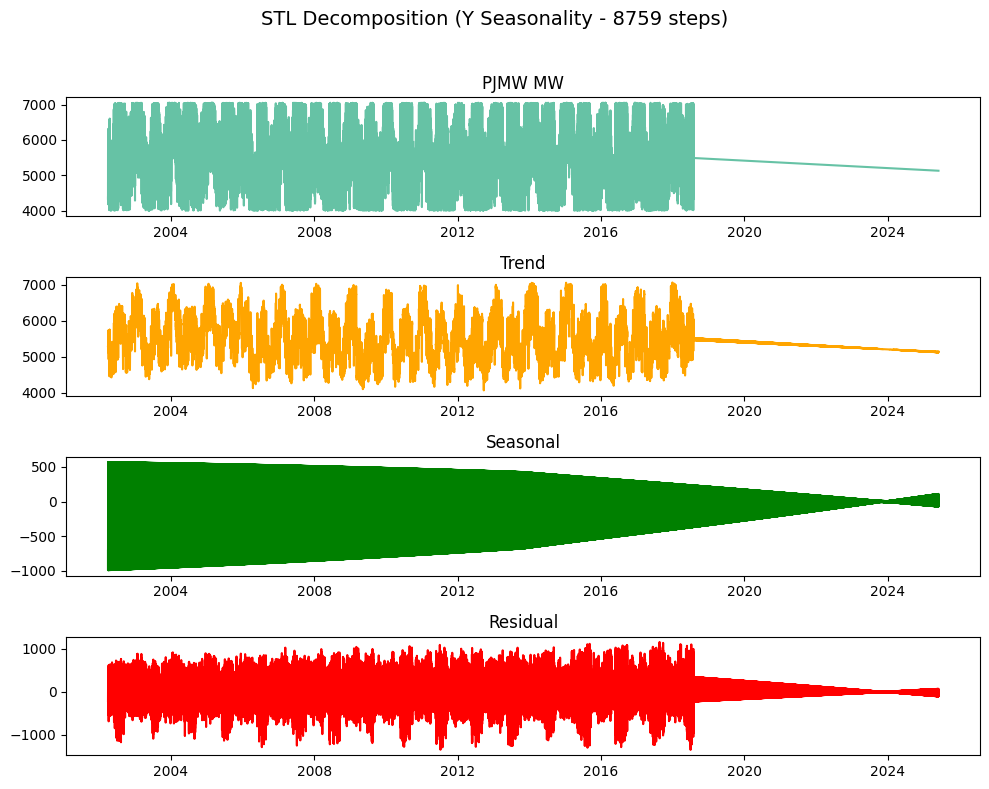

In [ ]:
plot_stl_decomposition(df['PJMW_MW_cleaned'], freq='Y', column_name='PJMW MW')  #Yearly

**MODEL BUILDING**

In [ ]:
#=== INSTALL DEPENDENCIES ===
!pip install xgboost lightgbm scikit-learn seaborn tensorflow --quiet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
sns.set_palette('Set2')
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping


AttributeError: module 'numpy' has no attribute 'dtypes'

In [ ]:
df = pd.read_csv('/content/PJMW_hourly_cleaned (1).csv')

In [ ]:
df.head()

,Unnamed: 0,Datetime,PJMW
0,0,2002-04-01 01:00:00,4374.0
1,1,2002-04-01 02:00:00,4306.0
2,2,2002-04-01 03:00:00,4322.0
3,3,2002-04-01 04:00:00,4359.0
4,4,2002-04-01 05:00:00,4436.0


In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True)
#df.rename(columns={'PJMW_MW_cleaned':'PJMW'}, inplace=True)

In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True)

df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df = df.sort_index()
df= df.asfreq('h')

In [ ]:
df.head()

,PJMW
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0


In [ ]:
df.shape

(143232, 1)

| **Use Case**                         | **Recommended Model**  |
| ------------------------------------ | ---------------------- |
| Simple trend/seasonality             | ARIMA, Holt-Winters    |
| Complex multivariate data            | VAR, Random Forest     |
| Large dataset with sequence patterns | LSTM, Transformer      |
| Business forecasting                 | Prophet, NeuralProphet |
| Long-term sequence dependencies      | TCN, Transformer       |


In [ ]:
import numpy as np

print(np.__version__)

1.24.4


In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("/content/PJMW_hourly_cleaned (1).csv", parse_dates=['Datetime'], index_col='Datetime')
df.drop("Unnamed: 0", axis=1, inplace=True)
df = df.asfreq('h')  # or 'D', 'M' depending on your data frequency

# Fit ARIMA model
model = ARIMA(df, order=(3, 1, 8))  # (p,d,q) — tune accordingly
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=24)
print(forecast)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2018-08-03 01:00:00    5192.992617
2018-08-03 02:00:00    4987.527277
2018-08-03 03:00:00    4835.792212
2018-08-03 04:00:00    4760.823664
2018-08-03 05:00:00    4782.111792
2018-08-03 06:00:00    4874.410353
2018-08-03 07:00:00    5016.526901
2018-08-03 08:00:00    5200.862224
2018-08-03 09:00:00    5410.977619
2018-08-03 10:00:00    5631.814332
2018-08-03 11:00:00    5847.662482
2018-08-03 12:00:00    6044.283341
2018-08-03 13:00:00    6209.436330
2018-08-03 14:00:00    6333.717027
2018-08-03 15:00:00    6410.993204
2018-08-03 16:00:00    6438.652123
2018-08-03 17:00:00    6417.576844
2018-08-03 18:00:00    6351.894394
2018-08-03 19:00:00    6248.516422
2018-08-03 20:00:00    6116.517997
2018-08-03 21:00:00    5966.404432
2018-08-03 22:00:00    5809.322229
2018-08-03 23:00:00    5656.270450
2018-08-04 00:00:00    5517.365793
Freq: h, Name: predicted_mean, dtype: float64


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['PJMW'])
print(f'p-value: {result[1]}')  # p < 0.05 → stationary


p-value: 0.0


In [1]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot_acf(df['PJMW'].dropna(), lags=40)
# plot_pdacf(f['PJMW'].dropna(), lags=40)


In [ ]:
df.head()

,PJMW
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0


In [ ]:
test = df.iloc[-24:,:]
len(test)

24

In [ ]:
len(forecast)

24

In [ ]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 206.44
RMSE: 253.17
R² Score: 0.88


In [ ]:
# def create_time_features(df, target_col='PJMW'):
#     df = df.copy()

#     # Basic time features
#     df['hour'] = df.index.hour
#     df['dayofweek'] = df.index.dayofweek

#     # Lag and rolling statistics
#     df['lag_24'] = df[target_col].shift(24)
#     df['rolling_mean_24'] = df[target_col].rolling(window=24).mean()

#     # Drop rows with NaN values caused by lag/rolling
#     df.dropna(inplace=True)

#     return df

# df = create_time_features(df)

In [ ]:
df.head()

,PJMW
Datetime,
2002-04-01 01:00:00,4374.0
2002-04-01 02:00:00,4306.0
2002-04-01 03:00:00,4322.0
2002-04-01 04:00:00,4359.0
2002-04-01 05:00:00,4436.0


In [ ]:
# !pip uninstall numpy -y
# !pip uninstall -y pmdarima scikit-learn statsmodels
# !pip install numpy==1.24.3
# !pip install scikit-learn statsmodels

import numpy
print(numpy.__version__)

1.24.3


AttributeError: module 'numpy' has no attribute 'dtypes'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def prepare_lstm_data(df, target_col='PJMW'):
    df = df.copy()

    # Feature Scaling
    scaler = MinMaxScaler()
    feature_cols = ['hour', 'dayofweek', 'lag_24', 'rolling_mean_24']
    df[feature_cols + [target_col]] = scaler.fit_transform(df[feature_cols + [target_col]])

    # Features and Target
    X = df[feature_cols].values
    y = df[[target_col]].values

    # Reshape X for LSTM [samples, timesteps, features]
    X = X.reshape((X.shape[0], 1, X.shape[1]))  # 1 timestep

    return train_test_split(X, y, test_size=0.2, shuffle=False), scaler


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

(X_train, X_test, y_train, y_test), scaler = prepare_lstm_data(df)

model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

predictions = model.predict(X_test)

# Inverse scaling (if needed)
y_test_inv = scaler.inverse_transform(np.concatenate((X_test[:, 0, :-1], y_test), axis=1))[:, -1]
pred_inv = scaler.inverse_transform(np.concatenate((X_test[:, 0, :-1], predictions), axis=1))[:, -1]

In [ ]:
def create_time_features(df, target_col):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

    # Lag features
    for lag in [1, 2, 3, 24, 48, 168]:  # 1h, 2h, 3h, 1d, 2d, 1w
        df[f'lag_{lag}'] = df[target_col].shift(lag)

    # Rolling mean features
    for window in [3, 24, 168]:  # short, daily, weekly
        df[f'rolling_mean_{window}'] = df[target_col].shift(1).rolling(window=window).mean()

    # Drop NA values after lag/rolling creation
    df.dropna(inplace=True)
    return df


In [ ]:
def train_test_split_time_series(df, target_col, split_ratio=0.8):
    split_index = int(len(df) * split_ratio)
    train = df.iloc[:split_index]
    test = df.iloc[split_index:]

    X_train = train.drop(columns=[target_col])
    y_train = train[target_col]
    X_test = test.drop(columns=[target_col])
    y_test = test[target_col]

    return X_train, X_test, y_train, y_test


1.**BASELINE: LINEAR REGRESSION**

In [ ]:
def train_linear_regression(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    print(f"Linear Regression MAE: {mean_absolute_error(y_test, preds):.2f}")
    print(f"Linear Regression RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}")
    print(f"Linear Regression R2: {r2_score(y_test, preds):.2f}")

    return model, preds

In [ ]:
df_fe = create_time_features(df, target_col='PJMW')
X_train, X_test, y_train, y_test = train_test_split_time_series(df_fe, target_col='PJMW')

In [ ]:
model_lr, preds_lr = train_linear_regression(X_train, y_train, X_test, y_test)


Linear Regression MAE: 84.65
Linear Regression RMSE: 110.83
Linear Regression R2: 0.99


In [ ]:
def plot_predictions(y_test, preds, title=''):
    plt.figure(figsize=(15, 5))
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, preds, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

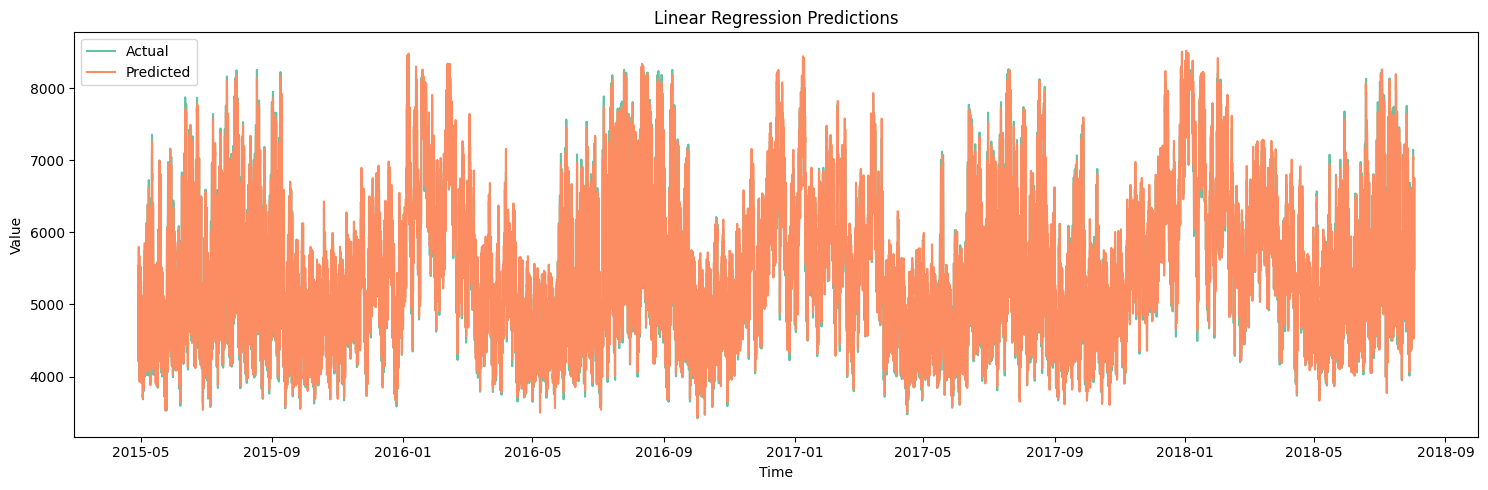

In [ ]:
plot_predictions(y_test, preds_lr, title="Linear Regression Predictions")

2.RANDOM FOREST

In [ ]:
def train_random_forest(X_train, y_train, X_test, y_test):
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    print(f"Random Forest MAE: {mean_absolute_error(y_test, preds):.2f}")
    print(f"Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}")
    print(f"Random Forest R2: {r2_score(y_test, preds):.2f}")

    return model, preds

In [ ]:
df_fe = create_time_features(df, target_col='PJMW')
X_train, X_test, y_train, y_test = train_test_split_time_series(df_fe, target_col='PJMW')

In [ ]:
model_rf, preds_rf = train_random_forest(X_train, y_train, X_test, y_test)

Random Forest MAE: 55.76
Random Forest RMSE: 73.60
Random Forest R2: 0.99


In [ ]:
def plot_predictions(y_test, preds, title=''):
    plt.figure(figsize=(15, 5))
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, preds, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

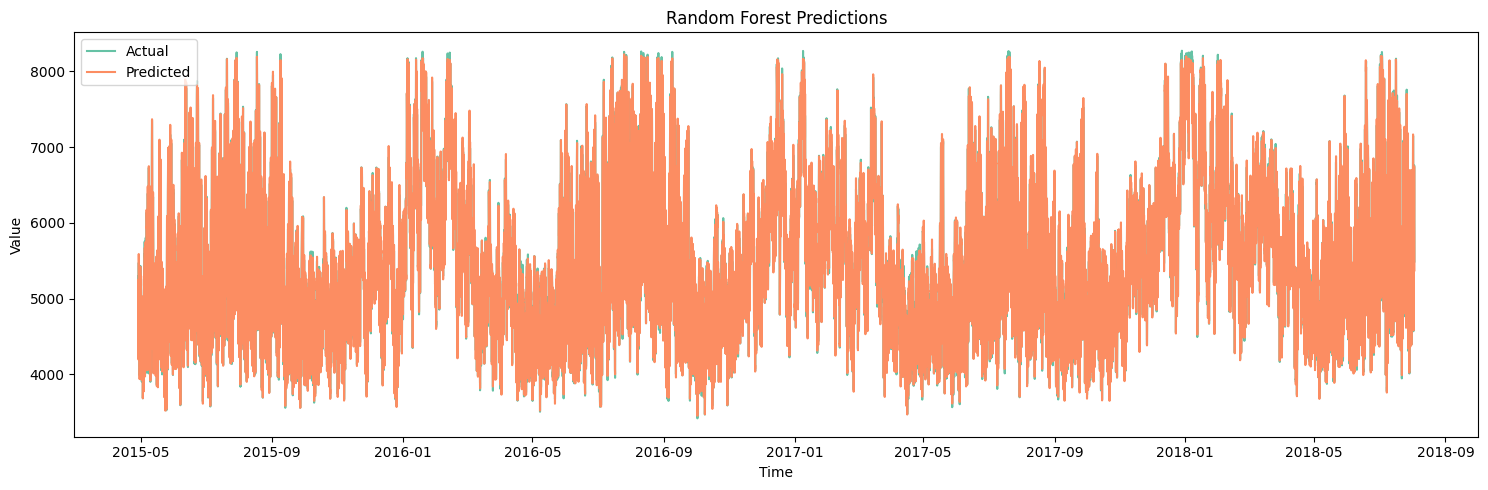

In [ ]:
plot_predictions(y_test, preds_rf, title="Random Forest Predictions")

**3. EXTRA TREES**

In [ ]:
def train_extra_trees(X_train, y_train, X_test, y_test):
    model = ExtraTreesRegressor(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    print(f"Extra Trees MAE: {mean_absolute_error(y_test, preds):.2f}")
    print(f"Extra Trees RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}")
    print(f"Extra Trees R2: {r2_score(y_test, preds):.2f}")

    return model, preds

In [ ]:
df_fe = create_time_features(df, target_col='PJMW')
X_train, X_test, y_train, y_test = train_test_split_time_series(df_fe, target_col='PJMW')

In [ ]:
model_et, preds_et = train_extra_trees(X_train, y_train, X_test, y_test)

Extra Trees MAE: 53.08
Extra Trees RMSE: 69.78
Extra Trees R2: 1.00


In [ ]:
def plot_predictions(y_test, preds, title=''):
    plt.figure(figsize=(15, 5))
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, preds, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

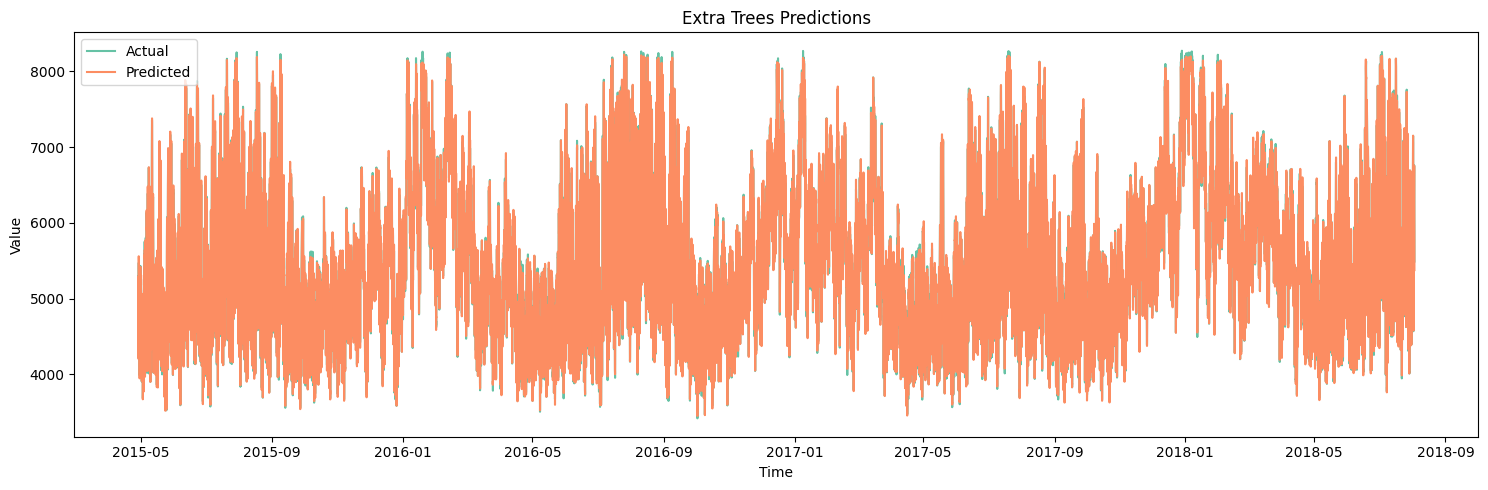

In [ ]:
plot_predictions(y_test, preds_et, title="Extra Trees Predictions")

**Gradient Boosting Model**

In [ ]:
# === XGBOOST ===

def train_xgboost(X_train, y_train, X_test, y_test):
    model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    print(f"MAE: {mean_absolute_error(y_test, preds):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}")
    print(f"R2: {r2_score(y_test, preds):.2f}")

    return model, preds



In [ ]:
# Step 1: Feature engineering
df_fe = create_time_features(df, target_col='PJMW')

In [ ]:
# Step 2: Train/test split
X_train, X_test, y_train, y_test = train_test_split_time_series(df_fe, target_col='PJMW')


In [ ]:
# Step 3: Train model
model, preds = train_xgboost(X_train, y_train, X_test, y_test)

MAE: 58.93
RMSE: 76.11
R2: 0.99


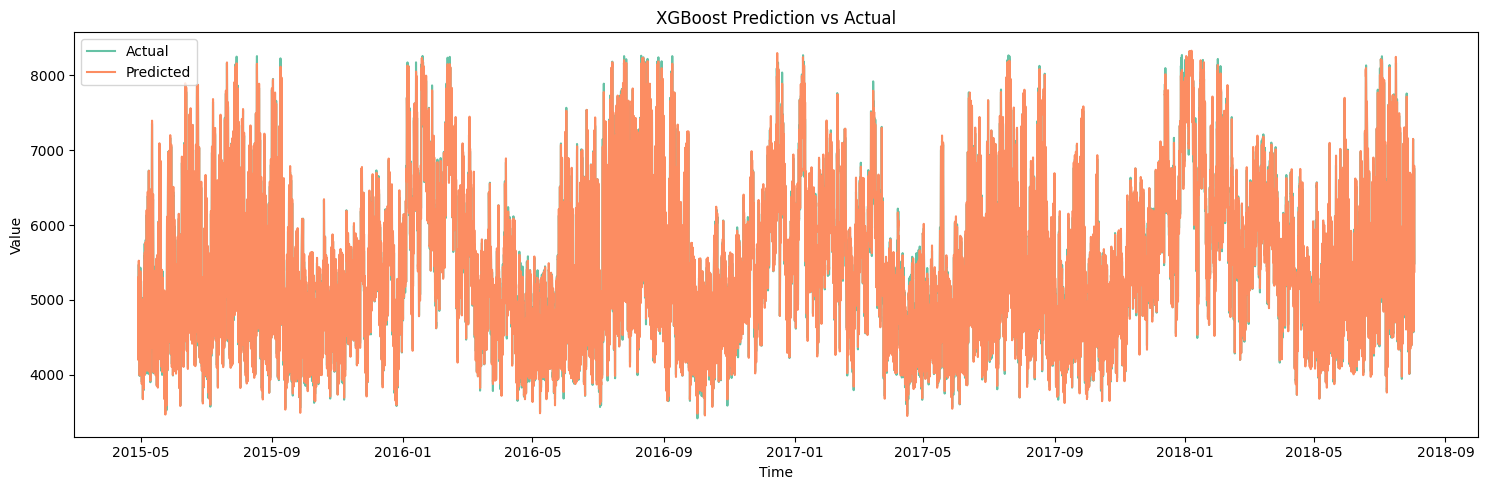

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, preds, label='Predicted')
plt.legend()
plt.title('XGBoost Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.tight_layout()
plt.show()


**Light Graient Boosting Model**

In [ ]:
# === LIGHTGBM ===
def train_lightgbm(X_train, y_train, X_test, y_test):
    model = lgb.LGBMRegressor(
        objective='regression',
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    print(f"MAE: {mean_absolute_error(y_test, preds):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}")
    print(f"R²: {r2_score(y_test, preds):.2f}")

    return model, preds



In [ ]:
# Step 4: Train LightGBM
model, preds = train_lightgbm(X_train, y_train, X_test, y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2687
[LightGBM] [Info] Number of data points in the train set: 114451, number of used features: 17
[LightGBM] [Info] Start training from score 5614.162109
MAE: 53.22
RMSE: 68.62
R²: 1.00


In [ ]:
def plot_feature_importance(model, feature_names, top_n=20):
    importance = model.feature_importances_
    feature_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_imp['Feature'][:top_n][::-1], feature_imp['Importance'][:top_n][::-1], color='skyblue')
    plt.xlabel("Feature Importance")
    plt.title(f"Top {top_n} Important Features (LightGBM)")
    plt.tight_layout()
    plt.show()



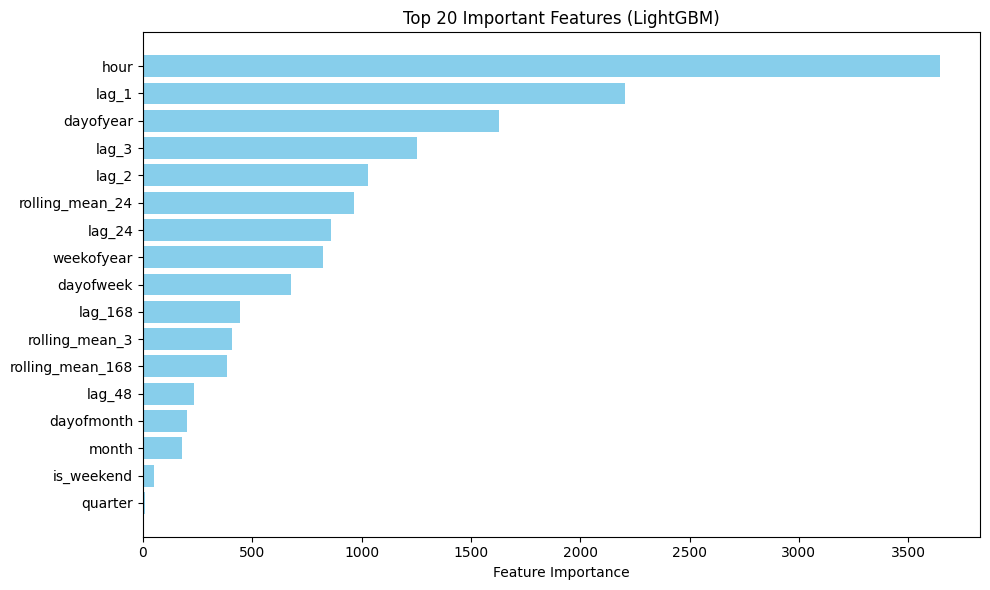

In [ ]:
# Call this after training your model:
plot_feature_importance(model, X_train.columns)

**Long Short- Term Memory(LSTM)**

In [ ]:
target_col = 'PJMW'

# Scale data
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df[[target_col]])
df_scaled = pd.DataFrame(scaled_values, index=df.index, columns=[target_col])

In [ ]:
# --------------------------
# Function to Create Sequences
# --------------------------
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [ ]:
# Create train-test split
sequence_length = 24  # using 24 past hours to predict next hour
split = int(len(df_scaled) * 0.8)
train, test = df_scaled[:split], df_scaled[split:]

In [ ]:
X_train, y_train = create_sequences(train[target_col].values, sequence_length)
X_test, y_test = create_sequences(test[target_col].values, sequence_length)

In [ ]:
# Drop the last row if y_test contains NaN
if np.isnan(y_test[-1]):
    X_test = X_test[:-1]
    y_test = y_test[:-1]

In [ ]:
# Reshape for LSTM: (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], sequence_length, 1))
X_test = X_test.reshape((X_test.shape[0], sequence_length, 1))

In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
3222/3222 ━━━━━━━━━━━━━━━━━━━━ 54s 16ms/step - loss: 0.0126 - val_loss: 7.3025e-04
Epoch 2/50
3222/3222 ━━━━━━━━━━━━━━━━━━━━ 83s 16ms/step - loss: 6.0818e-04 - val_loss: 6.3310e-04
Epoch 3/50
3222/3222 ━━━━━━━━━━━━━━━━━━━━ 83s 17ms/step - loss: 4.6929e-04 - val_loss: 3.8884e-04
Epoch 4/50
3222/3222 ━━━━━━━━━━━━━━━━━━━━ 81s 16ms/step - loss: 4.1493e-04 - val_loss: 5.1966e-04
Epoch 5/50
3222/3222 ━━━━━━━━━━━━━━━━━━━━ 54s 17ms/step - loss: 4.0107e-04 - val_loss: 4.0070e-04
Epoch 6/50
3222/3222 ━━━━━━━━━━━━━━━━━━━━ 81s 16ms/step - loss: 3.7894e-04 - val_loss: 3.8578e-04
Epoch 7/50
3222/3222 ━━━━━━━━━━━━━━━━━━━━ 52s 16ms/step - loss: 3.6257e-04 - val_loss: 4.0509e-04
Epoch 8/50
3222/3222 ━━━━━━━━━━━━━━━━━━━━ 89s 18ms/step - loss: 3.5215e-04 - val_loss: 3.2396e-04
Epoch 9/50
3222/3222 ━━━━━━━━━━━━━━━━━━━━ 55s 17ms/step - loss: 3.3202e-04 - val_loss: 3.0564e-04
Epoch 10/50
3222/3222 ━━━━━━━━━━━━━━━━━━━━ 79s 16ms/step - loss: 3.3597e-04 - val_loss: 3.0389e-04
Epoch 11/50
3222/3222 ━

895/895 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step


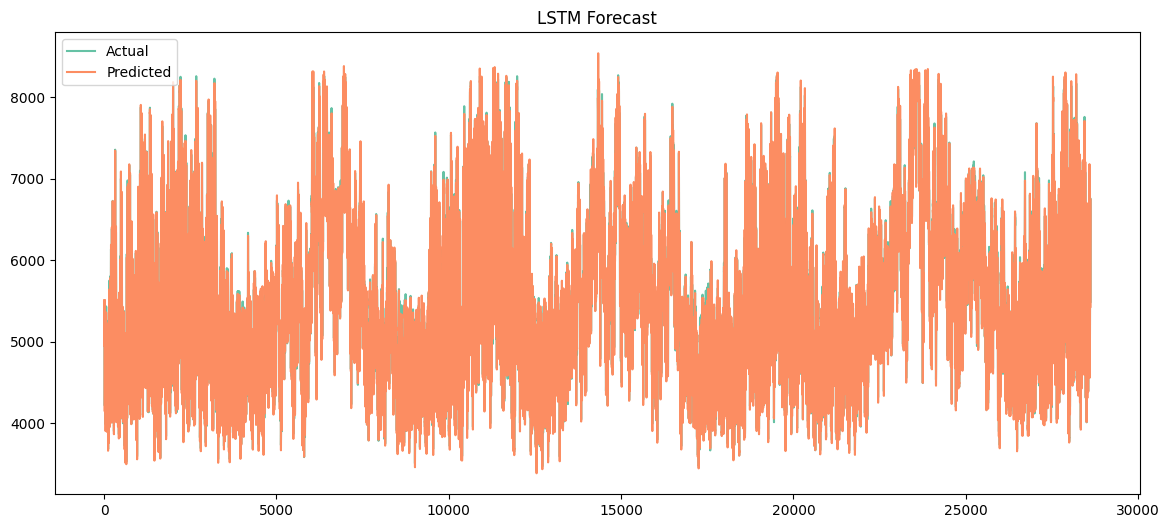

MAE: 55.46
RMSE: 72.89
R2: 0.99


In [ ]:
# Predict
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions
plt.figure(figsize=(14, 6))
plt.plot(actual, label='Actual')
plt.plot(pred, label='Predicted')
plt.title('LSTM Forecast')
plt.legend()
plt.show()

# Metrics
mae = mean_absolute_error(actual, pred)
rmse = np.sqrt(mean_squared_error(actual, pred))
r2 = r2_score(actual, pred)

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')


**Bidirectional LSTM**

In [ ]:
X_train, y_train = create_sequences(train[target_col].values, sequence_length)
X_test, y_test = create_sequences(test[target_col].values, sequence_length)

# Remove NaNs if needed
if np.isnan(y_test[-1]):
    X_test = X_test[:-1]
    y_test = y_test[:-1]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
# Reshape for LSTM [samples, time_steps, features]
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))



In [ ]:
# Define BiLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,921 (132.50 KB)

 Trainable params: 33,921 (132.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train
history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)



Epoch 1/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 115s 32ms/step - loss: 3.1183e-04 - val_loss: 2.4004e-04
Epoch 2/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 116s 32ms/step - loss: 3.1406e-04 - val_loss: 2.2528e-04
Epoch 3/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 119s 33ms/step - loss: 3.0956e-04 - val_loss: 2.3303e-04
Epoch 4/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 139s 33ms/step - loss: 3.0049e-04 - val_loss: 2.0955e-04
Epoch 5/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 142s 33ms/step - loss: 3.0773e-04 - val_loss: 2.0476e-04
Epoch 6/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 115s 32ms/step - loss: 2.9773e-04 - val_loss: 2.3808e-04
Epoch 7/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 115s 32ms/step - loss: 2.9467e-04 - val_loss: 2.3238e-04
Epoch 8/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 118s 33ms/step - loss: 2.9637e-04 - val_loss: 2.3534e-04
Epoch 9/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 142s 33ms/step - loss: 2.9697e-04 - val_loss: 2.0833e-04
Epoch 10/20
3581/3581 ━━━━━━━━━━━━━━━━━━━━ 141s 33ms/step - loss: 2.8675e-04 - val_loss: 2.0364e-04
Epoch 11/

895/895 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step


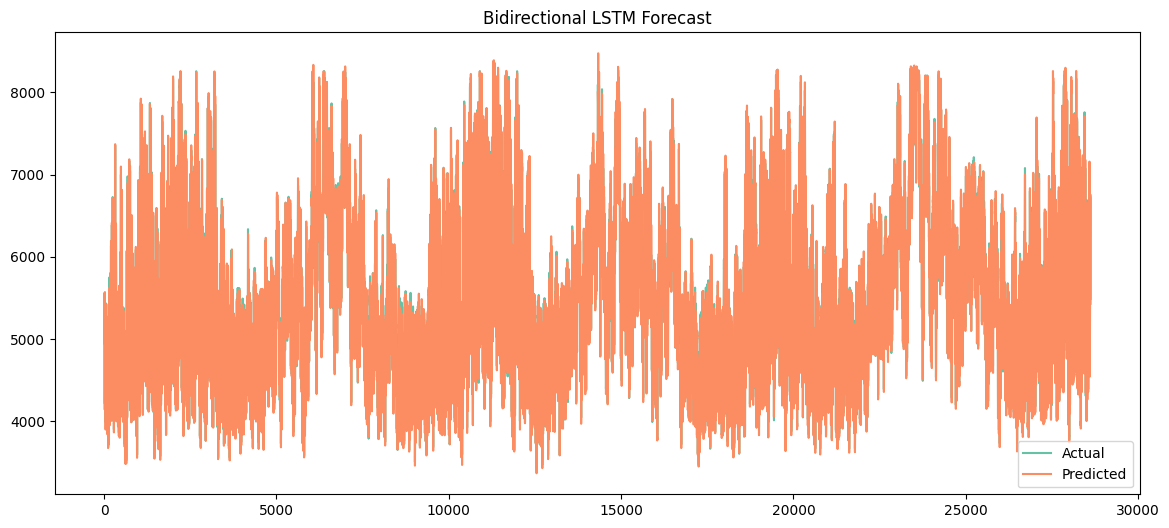

MAE: 55.54
RMSE: 73.13
R²: 0.99


In [ ]:
### 📊 Evaluate & Plot Results:


# Predict
pred_scaled = model.predict(X_test_reshaped).flatten()
pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
actual= scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Metrics
mae = mean_absolute_error(actual, pred)
rmse = np.sqrt(mean_squared_error(actual, pred))
r2 = r2_score(actual, pred)




# Plot predictions
plt.figure(figsize=(14, 6))
plt.plot(actual, label='Actual')
plt.plot(pred, label='Predicted')
plt.title('Bidirectional LSTM Forecast')
plt.legend()
plt.show()

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")



In [ ]:
results = [
    {'model': 'Linear Regression', 'MAE': 84.65, 'RMSE': 110.83, 'R2': 0.99},
    {'model': 'Random Forest', 'MAE': 55.76, 'RMSE': 73.60, 'R2':0.99},
    {'model': 'Extra Trees', 'MAE': 53.08, 'RMSE': 69.78, 'R2': 1.00},
    {'model': 'XGBoost', 'MAE':58.93, 'RMSE': 76.11, 'R2': 0.99},
    {'model': 'LightGBM', 'MAE':53.22, 'RMSE': 68.62, 'R2': 1.00},
    {'model': 'LSTM', 'MAE':55.89 , 'RMSE':74.63 , 'R2':0.99 },
    {'model': 'Bidirectional LSTM', 'MAE':55.54 , 'RMSE':73.13 ,'R2':0.99}
]


In [ ]:
# Convert to DataFrame and fill missing values with 'N/A'
metrics_df = pd.DataFrame(results)
metrics_df = metrics_df[['model', 'RMSE', 'MAE', 'R2']].sort_values(by='RMSE')

metrics_df

,model,RMSE,MAE,R2
4,LightGBM,68.62,53.22,1.00
2,Extra Trees,69.78,53.08,1.00
6,Bidirectional LSTM,73.13,55.54,0.99
1,Random Forest,73.60,55.76,0.99
5,LSTM,74.63,55.89,0.99
3,XGBoost,76.11,58.93,0.99
0,Linear Regression,110.83,84.65,0.99


<ipython-input-74-2d2377303049>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot=sns.barplot(data=results, x='model', y='RMSE', palette='viridis')


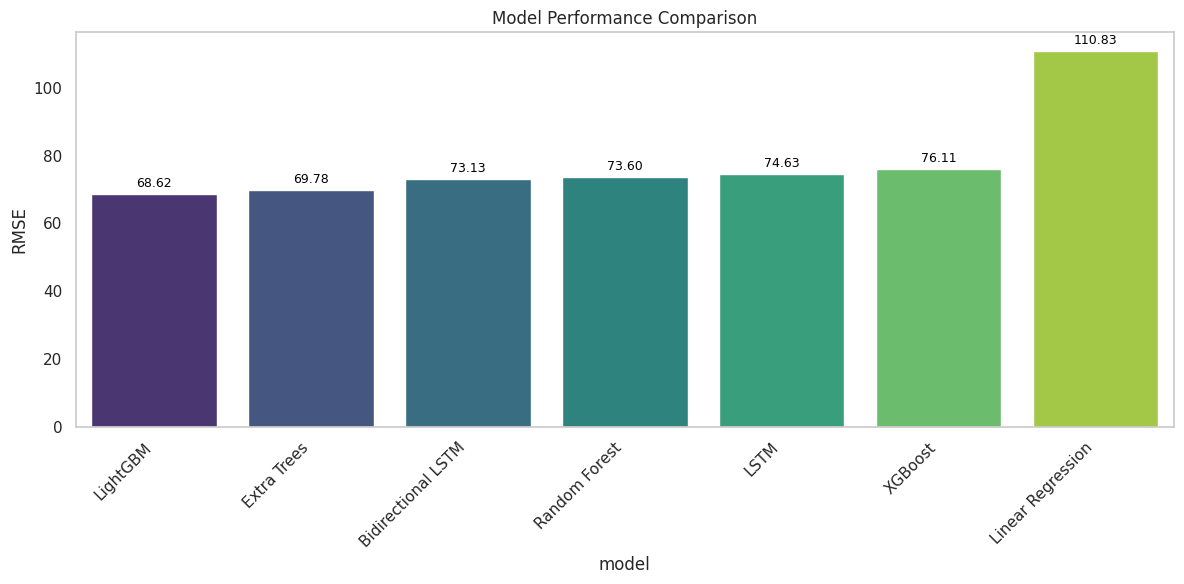

In [ ]:
# === VISUALIZE RESULTS ===
results = pd.DataFrame(results).sort_values(by='RMSE')
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
barplot=sns.barplot(data=results, x='model', y='RMSE', palette='viridis')
for i, bar in enumerate(barplot.patches):
    height = bar.get_height()
    barplot.annotate(f'{height:.2f}',
                     (bar.get_x() + bar.get_width() / 2., height),
                     ha='center', va='bottom',
                     fontsize=9, color='black', xytext=(0, 3),
                     textcoords='offset points')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

#lower the rmse better the model

In [10]:
import pandas as pd

# Load data
# df = pd.read_csv("/content/PJMW_hourly.csv")
df.columns = df.columns.str.strip()

# Convert to datetime and sort
df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Datetime'])
df = df.sort_values('Datetime')

# Set Datetime as index
df.set_index('Datetime', inplace=True)

# Downsample to daily frequency using mean (can use sum, median, etc.)
daily_df = round(df.resample('D').mean(), 2)

# Reset index if needed
daily_df = daily_df.reset_index()

# View result
print(daily_df.head())


FileNotFoundError: [Errno 2] No such file or directory: '/content/PJMW_hourly.csv'

In [13]:
daily_df.to_csv("PJMW_daily.csv", index=False)

In [17]:
df = pd.read_csv("/content/PJMW_daily.csv")
df.head()

,Datetime,PJMW_MW
0,2002-04-01,5271.17
1,2002-04-02,5310.42
2,2002-04-03,5325.92
3,2002-04-04,5670.79
4,2002-04-05,5686.12


In [18]:
df.set_index('Datetime', inplace=True)
df = df.sort_index()
df.head()

,PJMW_MW
Datetime,
2002-04-01,5271.17
2002-04-02,5310.42
2002-04-03,5325.92
2002-04-04,5670.79
2002-04-05,5686.12


In [19]:
len(df)

5969